In [1]:
# Packages we need
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Load datasets

# TO DO
    # add a dateparse -> this slows down the process so, it will be done
file_path = "C:/Users/Guillaume/Desktop/Algorithmic Methods/ADM Datasets/2019-Oct.csv"
df_oct = pd.read_csv(file_path, nrows=10000, parse_dates=["event_time"])

file_path = "C:/Users/Guillaume/Desktop/Algorithmic Methods/ADM Datasets/2019-Nov.csv"
df_nov = pd.read_csv(file_path, nrows=10000, parse_dates=["event_time"])

# We append nov to oct
df = df_oct.append(df_nov)
# We remove duplicates
df = df.drop_duplicates()

# Split the column category_code into its different components
df[["category","sub-category","product"]] = df["category_code"].str.split(".", expand=True)

# Extract Weekday names
df["weekday"] = df["event_time"].dt.day_name()
# Extract Month_names
df["months"] = df["event_time"].dt.month_name()
# Time of day
df["hour"] = df["event_time"].dt.hour

# R1 Complete Funnels Rate
A marketing funnel describes your customer’s journey with your e-commerce. It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond. Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase.

A complete funnel is the successive operations of view->cart->purchase realized during 1 session.

In [ ]:
# We group a first time to get the count an action appear for 1 product within 1 session
# We reset the index to be able to re-use the columns
funnel  = pd.DataFrame(df_1.groupby(['user_session',"product_id",'event_type']).event_type.count()).rename(columns={'event_type':'count'}).reset_index()

# We group a second time, this time to count the number of unique event type appear for 1 product within 1 session
# We reset the index
funnel  = pd.DataFrame(funnel .groupby(['user_session',"product_id"]).event_type.count()).rename(columns={'event_type':'count'}).reset_index()

# We know that a product when through a complete funnel if it has gonne through view->cart->purchase
# We filter for 3
count_complete_funnel = funnel[funnel ['count'] == 3].shape[0]

# The denominator as the total number of views. All views that begin are a potential funnel
# the rate is subject to interpretation
total_views = df[df.event_type =="view"].count()[0]

# We do the ratio
cfr = round(count_complete_funnel*100/total_views,2)

### Average number of times users perform each operation 

# R2 

### What are the categories of the most trending products overall? For each month visualize this information through a plot showing the number of sold products per category.

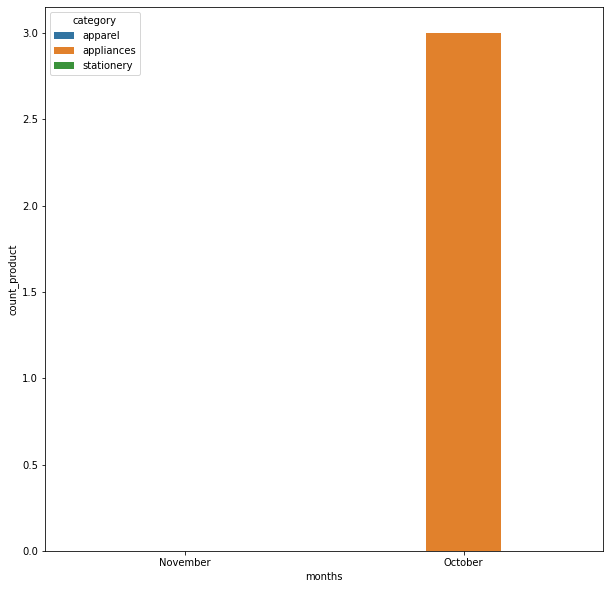

In [38]:
df_purchased_cat = df[df["event_type"]=="purchase"]
#df_purchased_cat = df_purchased_cat[["category","sub-category","product"]].fillna("unknown")
df_purchased_cat = pd.DataFrame(df_purchased_cat.groupby(["category","months"]).product.count()).rename(columns={'product':'count_product'}).reset_index()
fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(x="months", y="count_product", hue="category", data=df_purchased_cat, ax=ax1)

 ### Plot the most visited subcategories

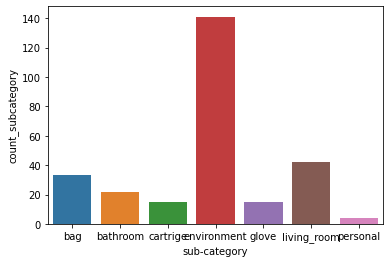

In [38]:
df_view_subcat = df[df["event_type"]=="view"]
df_view_subcat = pd.DataFrame(df_view_subcat.groupby(["sub-category"]).event_type.count()).rename(columns={'event_type':'count_subcategory'}).reset_index()
df_view_subcat.sort_values(["count_subcategory"], ascending=False)
# The x axis will be crowded.
sns.barplot(x="sub-category", y="count_subcategory", data=df_view_subcat )

What are the 10 most sold products per category?

In [39]:
# We replace months by product in the first grouping

df_purchased_cat = df[df["event_type"]=="purchase"]
#df_purchased_cat = df_purchased_cat[["category","sub-category","product"]].fillna("unknown")
df_purchased_cat = pd.DataFrame(df_purchased_cat.groupby(["category","product"]).product.count()).rename(columns={'product':'count_product'}).reset_index()

# nlargest does not work. So i guess we have to work with groupby
df_purchased_cat.groupby(["category","product"]).head(10).sort_values(["category","count_product"])

,category,product,count_product
0,appliances,vacuum,3


What to do with all the empty values

# R3
### For each category, what’s the brand whose prices are higher on average?

In [41]:
df_brand_avg_price = pd.DataFrame(df.groupby(["category","brand"]).price.mean()).rename(columns={'price' : 'mean_price'}).reset_index()
df_brand_avg_price = df_brand_avg_price.sort_values(by = ['mean_price'],ascending=False)
df_brand_avg_price = df_brand_avg_price.groupby(['category']).head(1)
print(df_brand_avg_price)

       category      brand  mean_price
14    furniture   kosmekka  150.790000
8    appliances        max   74.299167
0   accessories      vosev   62.700000
4       apparel   nitrimax   10.288000
16   stationery  depilflax    3.020000


### Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.

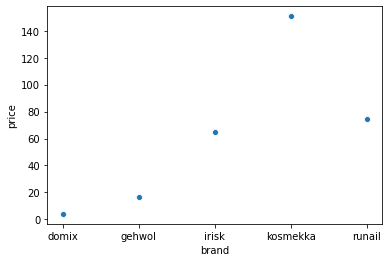

In [43]:
def plot_avg_price_product_brand(category):

    df_brand_avg_price = pd.DataFrame(df.groupby(["category","brand"]).price.mean()).reset_index()
    df_plot = df_brand_avg_price[df_brand_avg_price["category"]==category]
    sns.scatterplot(data= df_plot, x="brand", y="price")
    plt.show()

test = plot_avg_price_product_brand("furniture")

### Find, for each category, the brand with the highest average price. Return all the results in ascending order by price.
that's the same as before

# R4
### How much does each brand earn per month?

In [49]:
# good option
df_revenue = df[df["event_type"] == "purchase"]
df_revenue_2 = pd.DataFrame(df_revenue.groupby(["brand","months"]).price.sum()).reset_index()
print(df_revenue_2.head(10))

  brand   months  revenues
0   max  October     47.46
        brand    months   price
0    airnails  November    0.95
1    airnails   October    2.38
2      ardell  November    7.16
3  art-visage   October    8.02
4     beautix  November   15.71
5     beautix   October   42.39
6  beauugreen   October   15.71
7     bioaqua  November   21.43
8     bluesky  November   47.16
9     bluesky   October  151.17


### Write a function that given the name of a brand in input returns, for each month, its profit. 

There is no way to access the cost - hence our only option to compute revenues

In [72]:
def brand_revenues(brand):
    
    df_revenue = df[df["event_type"] == "purchase"]
    df_revenue = df_revenue[df_revenue["brand"] == brand]
    df_revenue = pd.DataFrame(df_revenue.groupby(["brand","months"]).price.sum()).reset_index()
    
    return df_revenue

### Is the average price of products of different brands significantly different?

First --> we need the average price of products for each brand.
Second --> A box plot is one option to visualize this difference

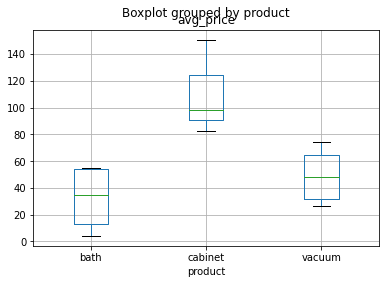

In [68]:
# New Option
df_op1 = pd.DataFrame(df.groupby(["brand","product"]).price.mean()).rename(columns={"price":"avg_price"}).reset_index()
df_op1.boxplot(column = "avg_price",by="product")

# Would they need a statistical 

### Using the function you just created, find the top 3 brands that have suffered the biggest losses in earnings between one month and the next, specifing bothe the loss percentage and the 2 months (e.g., brand_1 lost 20% between march and april).

In [123]:
# Lets get all the possible brands
brand_list = list(df["brand"].unique())

#New df to append
df_new = pd.DataFrame()
for brand in brand_list:
    test = brand_revenues(brand)
    df_new = df_new.append(test, ignore_index=True)

# We only want the brands for which there is earnings for oct and nov
# We create a filter we put an >= 2 in case we have more than 2 months later
df_2_months = pd.DataFrame(df_new.groupby(["brand"]).months.count()).reset_index()
df_2_months = df_2_months[df_2_months["months"]>=2]

# We can sort so that Nov is above Oct. 
# We shall get fucked later if we don't sort by time instead
df_new.sort_values(["brand","months"], ascending=True)
df_new = pd.merge(df_new, df_2_months, how="inner", on=["brand"])
# beautfil pct_change thingy
df_new["pct_change"] = df_new["price"].pct_change(periods=-1)
#"cannot reindex from a duplicate axis" so you must ignore_index in the for loop 

# We only want the month other than October, since it is the "first" month,

print(df_new[df_new["months_x"] != "October"].sort_values(["pct_change"]).head(3))

       brand  months_x  price  months_y  pct_change
52     smart  November   5.56         2   -0.805390
36   concept  November  11.59         2   -0.804520
58  severina  November   3.57         2   -0.783505


# R5 
In what part of the day is your store most visited?  

In [18]:
df_view = df[df["event_type"] == "view"]
freq= pd.DataFrame(df_view["hour"].value_counts()).rename(columns={"hour":"Total Views"}).reset_index().rename(columns={"index":"Time"})
print(freq)

   Time  Total Views
0     5         2540
1     4         2230
2     3         1331
3     0          936
4     1          850
5     2          805


Knowing which days of the week or even which hours of the day shoppers are likely to visit your online store and make a purchase may help you improve your strategies. 

### Create a plot that for each day of the week show the hourly average of visitors your store has.

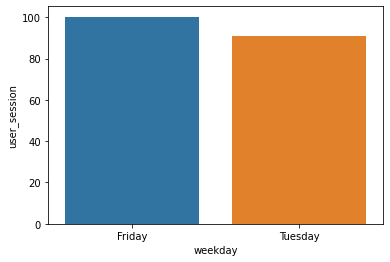

In [124]:
# First we group by session
df = pd.DataFrame(df.groupby(["user_session"]).event_time.min()).reset_index()
# Add the week day name
df["weekday"] = df["event_time"].dt.day_name()
# groupby weekday and count
df = pd.DataFrame(df.groupby(["weekday"]).user_session.count()).reset_index()
df["user_session"]=df["user_session"]/24

sns.barplot(data=df, x="weekday", y="user_session")
plt.show()

# R6
The conversion rate of a product is given by the number of times a product has been bought over the number of times it has been visited.

In [30]:
df_1 = pd.DataFrame(df[df["event_type"]=="view"].groupby(["product"]).product.count())\
.rename(columns={'product':'Total_View'}).reset_index()
df_2 = pd.DataFrame(df[df["event_type"]=="purchase"].groupby(["product"]).product.count())\
.rename(columns={'product':'Total_Purchase'}).reset_index()

df_cvr = pd.merge(df_1,df_2, how="left", on=["product"]).fillna(0)
df_cvr["CVR %"] = round((df_cvr["Total_Purchase"]/df_cvr["Total_View"])*100,2)
df_cvr.sort_values("CVR %", ascending=False)
print(df_cvr)

       product  Total_View  Total_Purchase  CVR %
0         bath          22             0.0   0.00
1      cabinet          42             0.0   0.00
2  hair_cutter           4             0.0   0.00
3       vacuum         141             3.0   2.13


### What's the conversion rate of your online store? Find the overall conversion rate of your store.

In [37]:
df_cvr["Total_Purchase"].sum() / df_cvr["Total_View"].sum()

0.014354066985645933

### Plot the number of purchases of each category and show the conversion rate of each category in decreasing order.

In [ ]:
# Need to change the style -> cuz it's ugly as fuck

# sns.set_style("white")
# fig, ax = plt.subplots()
# ax.plot(df_cvr["Total_View"])
# ax2 =ax.twinx()
# ax2.plot(df_cvr["CVR %"])
# sns.despine(ax=ax, right=True, left=True)
# sns.despine(ax=ax2, left=True, right=False)
# plt.show()

# RQ7 
Prove that the Pareto principle applies to your store